In [1]:
import numpy as np
import numpy.linalg as la
import scipy as sp
from scipy.linalg import block_diag
import random
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from math import pi, sqrt
import time

In [2]:
def initialize_wf_2D(nx,ny,n_e):
    n_loc=np.zeros((ny,nx),dtype= 'int')        
    config=np.sort(random.sample(range(nx*ny),n_e))

    n_loc[np.floor(config/nx).astype(int),config%nx]=np.ones((n_e,))
    n_ind = np.zeros((ny,nx),dtype=int)        
    n_ind[np.floor(config/nx).astype(int),config%nx] = np.arange(1,n_e+1)
    
    return n_loc, config, n_ind

def wf_gen_2D(nx,ny,n_e,BCx,BCy,t):
    h1=np.ones(nx*ny-1)       # Hopping in +x direction
    h1[nx-1::nx]=0
    
    h2 = np.zeros(nx*ny-nx+1,dtype = 'complex') 
    h2[0::nx]=np.conj(BCx)    #Boundary condition for looping in -x-direction
    
    h3=np.ones(nx*ny-nx)      #  Hopping in +y direction
    
    h4=np.conj(BCy)*np.ones(nx,dtype = 'complex')# BC in -y direction
    
    hop= t*(np.diag(h1,1)+np.diag(h2,nx-1) + np.diag(h3,nx) + np.diag(h4,nx*ny-nx))
    
    H_t= -(hop+ np.matrix(hop).H)/2 
    
    energies, evecs= np.linalg.eigh(H_t)
    return evecs[:,:n_e]

def WF_MAT(wf_gen, config):
    n_e = len(config)
    wf = np.zeros((n_e,n_e),dtype = "complex")
    wf = np.transpose(wf_gen[config,:])
     
    return wf

In [3]:
nx=4; ny = 2;
n_e= int(nx*ny/2)
BCx =1; BCy = 1
t = 1

n_loc,config,n_ind = initialize_wf_2D(nx,ny,n_e)    

print(n_loc)
print( config)
print( n_ind)

[[0 1 0 1]
 [1 0 1 0]]
[1 3 4 6]
[[0 1 0 2]
 [3 0 4 0]]


In [5]:
def run_negativity_2D(Orbitals, wf_r, config_r, n_loc_r, n_ind_r,nx,ny, n_e, n_configs, check_step,t,BCx,BCy, inds_A,inds_A1,inds_A2):
    
    move_attempted=0.0
    move_accepted=0.0
    i_up = (np.arange(r)+1)%r
    i_down = (np.arange(r)-1)%r

    n_i = np.arange(nx*ny)
    x_loc = n_i%nx
    y_loc = (n_i/nx).astype(int)

    #min_state = 5
    #n_hop = 3

    rel= np.zeros(((n_configs+min_state)*(check_step),n_e),dtype=complex)

    wf_inv_r = np.zeros(wf_r.shape,dtype=np.complex128)
    for i_r in range(r):
        wf_inv_r[:,:,i_r]=np.linalg.inv(wf_r[:,:,i_r])

    count_ent=0      # counter for entropy
    count_neg=0  #counter for negativity
    ent_ratio=np.zeros(n_configs,dtype= np.complex128)
    neg_ratio=np.zeros(n_configs,dtype= np.complex128)

    step_abs=np.arange(1,n_hop+1) #possible steps of random walk
    step_vals=np.sort(np.concatenate((-step_abs,step_abs),axis=0)).tolist() #Makes a list of steps from -n_hop to n_hop

    for state in range(0,n_configs+min_state):                              #Number of measurements
        for step in range(0,check_step):                               #Number of steps before measurement

            for i_r in range(r):
                for moved_e in range(0,n_e):                               #Move each electron individually           
                    move_attempted+=1

                    stepx=random.sample(step_vals,1)[0]
                    stepy=random.sample(step_vals,1)[0]

                    x_new = np.mod(x_loc[config_r[moved_e,i_r]]+stepx ,nx)
                    y_new = np.mod(y_loc[config_r[moved_e,i_r]]+stepy ,ny)
                    pts= nx*y_new+x_new          #Random walk of with hops in (-n_hop,n_hop) on torus                   


                    if n_loc_r[y_new,x_new,i_r]==1:                                      #Ensure new location is unoccupied
                        continue

                    u_0 = np.transpose(Orbitals[pts,:] - Orbitals[config_r[moved_e,i_r],:])
                    r_det =  np.dot(Orbitals[pts,:],wf_inv_r[moved_e,:,i_r].reshape((n_e,1)))

                    rel[state*(check_step) + step,moved_e] = np.abs(r_det)**2

                    accept_level = min(1,np.abs(r_det)**2)
                    #accept_level = min(1,np.abs(r_det)**4)  #For H-S states

                    random_num = random.random()

                    if random_num < accept_level:
                        move_accepted += 1

                        #Sherman-Morisson Formula for updating inverse matrix
                        v=np.zeros((n_e,1))
                        v[moved_e]=1
                        num = np.dot(np.dot(np.dot(wf_inv_r[:,:,i_r],u_0),v.T),wf_inv_r[:,:,i_r])
                        denom = (1+np.dot(v.T,np.dot(wf_inv_r[:,:,i_r],u_0)))
                        wf_inv_r[:,:,i_r] = wf_inv_r[:,:,i_r] - num/denom 
                        wf_r[:,moved_e,i_r] = np.reshape(np.transpose(Orbitals[pts,:]),(n_e,))

                        delta= np.zeros((ny,nx))
                        delta[y_loc[config_r[moved_e,i_r]],x_loc[config_r[moved_e,i_r]]] = -1
                        delta[y_loc[pts],x_loc[pts]]=1

                        n_loc_r[:,:,i_r] = n_loc_r[:,:,i_r] + delta
                        n_ind_r[:,:,i_r] = n_ind_r[:,:,i_r] + (moved_e + 1)*delta
                        config_r[moved_e,i_r] = pts                             #Update configuration

                x=np.argwhere(n_loc_r[:,:,i_r]>0)
                assert len(x)== n_e, 'no of ptcle is %d' % (len(x))
                assert np.sum(n_loc_r[:,:,i_r])== n_e, 'n_occ anc ptcle is %d' % (np.sum(n_loc_r[:,i_r]))


    #########   Edit Below this line   ########
        if state> (min_state-1):

            number_pt_inside_A= np.sum(n_loc_r[inds_A][:],axis=0)

            t_A1 = np.zeros(r,dtype = 'int')
            t_A2 = np.zeros(r,dtype = 'int')
            number_pt_inside_A1= np.sum(n_loc_r[inds_A1][:],axis=0); t_A1 =number_pt_inside_A1
            number_pt_inside_A2= np.sum(n_loc_r[inds_A2][:],axis=0); t_A2 =number_pt_inside_A2

            ratio_n = 1.0 + 0j
            #ratio_n_nophase = 1.0 + 0j
            ratio_e = 1.0 + 0j
            phase_r = np.ones(r,dtype = np.complex128)
            wf_swap = np.zeros(wf_r[:,:,i_r].shape,dtype=np.complex128)
            wf_swap_ent = np.zeros(wf_r[:,:,i_r].shape,dtype=np.complex128)

            check_1 = number_pt_inside_A
            check_2 = number_pt_inside_A1[i_up]+number_pt_inside_A2[i_down]
            comparison = check_1 == check_2

            if np.max(number_pt_inside_A)==np.min(number_pt_inside_A):
                for i_r in range(r):
                    Config_A1_up = np.argwhere( n_loc_r[:,:,i_up[i_r]][inds_A1]>0 )
                    Config_A1_up = np.reshape( Config_A1_up, (len(Config_A1_up),)).tolist()
                    Wf_inds_up = ( n_ind_r[:,:,i_up[i_r]][inds_A1][Config_A1_up] )-1

                    Config_A2_down = np.argwhere( n_loc_r[:,:,i_down[i_r]][inds_A2]>0 )
                    Config_A2_down = np.reshape( Config_A2_down, (len(Config_A2_down),)).tolist()
                    Wf_inds_down = ( n_ind_r[ :,:,i_down[i_r]][inds_A2][Config_A2_down] )-1

                    Config_AA = np.argwhere( n_loc_r[:,:,i_r][inds_A]>0 )
                    Config_AA = np.reshape( Config_AA, (len(Config_AA),)).tolist()
                    Wf_inds_AA= ( n_ind_r[:,:,i_r][inds_A][Config_AA]  )-1

                    Config_A_up = np.argwhere( n_loc_r[:,:,i_up[i_r]][inds_A]>0 )
                    Config_A_up = np.reshape( Config_A_up, (len(Config_A_up),)).tolist()
                    Wf_inds_A_up = ( n_ind_r[:,:,i_up[i_r]][inds_A][Config_A_up]  )-1

                    wf_swap_ent= np.copy(wf_r[:,:,i_r])
                    wf_swap_ent[:,Wf_inds_AA] = np.copy(wf_r[:,Wf_inds_A_up,i_up[i_r]])
                    ratio_e*=np.linalg.det(wf_swap_ent)/np.linalg.det(wf_r[:,:,i_r])

                    if len(Wf_inds_AA) == len(Wf_inds_up)+len(Wf_inds_down):
                        wf_swap = np.copy(wf_r[:,:,i_r])
                        wf_swap[:,Wf_inds_AA[0:len(Wf_inds_up)]] = np.copy(wf_r[:,Wf_inds_up,i_up[i_r]]) #Shifting forward
                        wf_swap[:,Wf_inds_AA[len(Wf_inds_up):len(Wf_inds_up)+len(Wf_inds_down)]] = np.copy(wf_r[:,Wf_inds_down,i_down[i_r]]) #Shifting back

                        #phase_r[i_r] = (-1)**((-1)**(i_r)*((int(t_A2[i_down[i_r]])+int(t_A2[i_r]))%2)/2 +int((t_A2[i_r]+t_A2[i_down[i_r]])*(t_A1[i_r]+t_A1[i_up[i_r]])))

                        ratio_n*=phase_r[i_r]*np.linalg.det(wf_swap)/np.linalg.det(wf_r[:,:,i_r])
                        count_neg+=1

                    else: 
                        ratio_n= 0

            elif comparison.all(): 
                for i_r in range(r):
                    config_A1_up = np.argwhere( n_loc_r[:,:,i_up[i_r]][inds_A1]>0 )
                    config_A1_up = np.reshape( config_A1_up, (len(config_A1_up),)).tolist()
                    wf_inds_up = ( n_ind_r[:,:,i_up[i_r]][inds_A1][config_A1_up] )-1

                    config_A2_down = np.argwhere( n_loc_r[:,:,i_down[i_r]][inds_A2]>0 )
                    config_A2_down = np.reshape( config_A2_down, (len(config_A2_down),)).tolist()
                    wf_inds_down = ( n_ind_r[ :,:,i_down[i_r]][inds_A2][config_A2_down] )-1

                    config_AA = np.argwhere( n_loc_r[:,:,i_r][inds_A]>0 )
                    config_AA = np.reshape( config_AA, (len(config_AA),)).tolist()
                    wf_inds_AA= ( n_ind_r[:,:,i_r][inds_A][config_AA]  )-1 

                    #n_loc_swap = np.copy(n_loc_r[:,i_r])
                    #n_loc_swap[inds_A1] = n_loc_r[inds_A1,i_up[i_r]]
                    #n_loc_swap[inds_A2] = n_loc_r[inds_A2,i_down[i_r]]

                    #phase_HS = (-1)**(np.sum(np.argwhere( n_loc_r[:,i_r]>0 )))
                    #phase_HS_swap = (-1)**(np.sum(np.argwhere( n_loc_swap>0 )))

                    wf_swap = np.copy(wf_r[:,:,i_r])
                    wf_swap[:,wf_inds_AA[0:len(wf_inds_up)]] = np.copy(wf_r[:,wf_inds_up,i_up[i_r]]) #Shifting forward
                    wf_swap[:,wf_inds_AA[len(wf_inds_up):len(wf_inds_up)+len(wf_inds_down)]] = np.copy(wf_r[:,wf_inds_down,i_down[i_r]]) #Shifting back

                    #phase_r[i_r] = (-1)**((-1)**(i_r)*((int(t_A2[i_down[i_r]])+int(t_A2[i_r]))%2)/2 +int((t_A2[i_r]+t_A2[i_down[i_r]])*(t_A1[i_r]+t_A1[i_up[i_r]])))

                    ratio_n*=phase_r[i_r]*np.linalg.det(wf_swap)/np.linalg.det(wf_r[:,:,i_r])
                    #ratio_n*=(phase_r[i_r]**2)*np.linalg.det(wf_swap)**2/np.linalg.det(wf_r[:,:,i_r])**2
                    #ratio_n_nophase*= phase_HS*phase_HS_swap*np.abs(np.linalg.det(wf_swap))**2/np.abs(np.linalg.det(wf_r[:,:,i_r]))**2 # H-S comp #Needs absolute value and negative phase?
                    #ratio_n_nophase*=phase_r[i_r]*np.linalg.det(wf_swap)/wf_det[i_r]
                    count_neg+=1
                    ratio_e = 0

            else:
                ratio_n = 0
                #ratio_n_nophase = 0
                ratio_e = 0

            neg_ratio[state -min_state] = ratio_n
            ent_ratio[state -min_state] = ratio_e
            #ent_ratio[state -min_state] = ratio_n_nophase

        if (state%500) ==0:
            for i_r in range(r):
                wf_inv_r[:,:,i_r]=np.linalg.inv(wf_r[:,:,i_r])   



    acc_ratio = move_accepted/move_attempted 

    #print("Negativity computed %d times" % (count_neg/r))
    print("Entropy is approximately " ,  (np.log(np.mean(ent_ratio))/(1-r)) ) 
    print("Negativity is approximately " , -(np.log(np.mean(neg_ratio))))
    #print("the acceptance rate=", acc_ratio)

        #(np.log(np.mean(neg_ratio)/np.mean(ent_ratio))/(1-r))


    return(np.log(np.mean(neg_ratio)), np.log(np.mean(ent_ratio))/(1-r))

In [11]:
###########Initialization###############

nx = 4                          # Length of lattice in x-direction
ny = 8                          # Length of lattice in x-direction
n_e = np.int(nx*ny/2)           # Number of electrons
n_hop = 3                       # maximum length of random walk in both direcions

t = 1                           #Hopping strength
BCx= -1 #np.exp(1j*np.pi/3)     #Boundary condition in x-direction
BCy= -1 #np.exp(1j*np.pi/3)     #Boundary condition in y-direction
r=2                            #Moment of Renyi entropy/Negativity to be detected

Ly_list= np.arange(1,ny+1,1)  #x-length of subsystems checked, starting from 0'th site

Orbitals = wf_gen_2D(nx,ny,n_e,BCx,BCy,t)  #First n_e eigenstates
                                                                                                                 
n_configs = 50000                 #Number of configurations evaluated (measurements made)
check_step =2                   #Number of cycles between evaluations
min_state = 5                  #Number of evaluation cycles before starting data collection

Rr_vmc=np.zeros(len(Ly_list), dtype=np.complex64)
Nr_vmc=np.zeros((len(Ly_list),1), dtype=np.complex64)

wf_r= np.zeros((n_e,n_e,r),dtype=np.complex64)
n_loc_r= np.zeros((ny,nx,r),dtype=int)
config_r= np.zeros((n_e,r),dtype=int)
n_ind_r = np.zeros((ny,nx,r),dtype=int)
cond_r = np.zeros(r)

######################## Evaluation ######################
t_timer=time.time()
random.seed(time.time())

for i_L in range(len(Ly_list)):
    
    Lsub=Ly_list[i_L]
    nx_A = int(nx/2)
    ny_A = Lsub
    print('subsystem size = {} x {}'.format(nx_A,ny_A)) 
    n_i_A = np.arange(nx_A*ny_A)
    inds_A =  tuple([np.floor(n_i_A/nx_A).astype(int),n_i_A%nx_A])

    ny_A1 = int(Lsub/2); ny_A2 = Lsub-int(Lsub/2)
    n_i_A1 = np.arange(nx_A*ny_A1)
    n_i_A2 = np.arange(nx_A*ny_A2)
    inds_A1 =  tuple([np.floor(n_i_A1/nx_A).astype(int),n_i_A1%nx_A])            #rectangle of dimension nx_A x (ny_A1)
    inds_A2 =  tuple([ny_A1+np.floor(n_i_A2/nx_A).astype(int),n_i_A2%nx_A])      #adjacent rectangle of nx_A x (ny_A2)
    print('partial-transpose region size = {} x {}'.format(nx_A,ny_A2))
    
    #A should always be split along the y-axis, else there will be a sign error in calculating negativity. 
    
    for i_r in range(r):
        n_loc_r[:,:,i_r], config_r[:,i_r], n_ind_r[:,:,i_r]=initialize_wf_2D(nx,ny,n_e)
        wf_r[:,:,i_r]=np.transpose(Orbitals[config_r[:,i_r],:])
        cond_r[i_r]=np.linalg.cond(wf_r[:,:,i_r])
            
    check= np.max(cond_r)
    counter=0
    epsilon= 1e-8
    while check > 1/epsilon:
        counter+=1
        assert counter<=10, "wave function cannot be constructed!"
        #Start from a configuration with equal numbers of particles in the region under consideration
        for i_r in range(r):
            n_loc_r[:,:,i_r], config_r[:,i_r], n_ind_r[:,:,i_r]=initialize_wf_2D(nx,ny,n_e)
            wf_r[:,:,i_r]=np.transpose(Orbitals[config_r[:,i_r],:])
            cond_r[i_r]=np.linalg.cond(wf_r[:,:,i_r])
            check = np.max(cond_r)  

    #Rr_vmc=[i_L] = 
    Nr_vmc[i_L],Rr_vmc[i_L]  = run_negativity_2D(Orbitals, wf_r, config_r, n_loc_r, n_ind_r,nx,ny, n_e, n_configs, check_step,t,BCx,BCy, inds_A,inds_A1,inds_A2)

    
elapsed = time.time() - t_timer
print("Program finished, elapsed time =", elapsed, "sec")

subsystem size = 2 x 1
partial-transpose region size = 2 x 1
Entropy is approximately  (1.1524734626620594-0j)
Negativity is approximately  (1.1524734445714093-0j)
subsystem size = 2 x 2
partial-transpose region size = 2 x 1
Entropy is approximately  (1.7451540508394832-0j)
Negativity is approximately  (1.7451540407243664-0j)
subsystem size = 2 x 3
partial-transpose region size = 2 x 2
Entropy is approximately  (2.0490828888630266-0j)
Negativity is approximately  (2.0490828825208713-0j)
subsystem size = 2 x 4
partial-transpose region size = 2 x 2
Entropy is approximately  (2.2200122770526396-0j)
Negativity is approximately  (2.2200122737163976-0j)
subsystem size = 2 x 5
partial-transpose region size = 2 x 3
Entropy is approximately  (2.70153469325576-0j)
Negativity is approximately  (2.7015346906686-0j)
subsystem size = 2 x 6
partial-transpose region size = 2 x 3
Entropy is approximately  (2.8806948823584286-0j)
Negativity is approximately  (2.8806948796694685-0j)
subsystem size = 2 x 

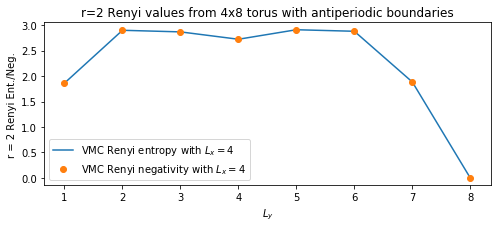

In [10]:
Nr_vmc_new = np.abs(Nr_vmc)
Rr_vmc_new = np.abs(Rr_vmc)

fig = plt.figure(figsize=(8.0, 3.0))
axes1 = fig.add_subplot(1, 1, 1)
axes1.set_ylabel("r = %d Renyi Ent./Neg." %(r))
axes1.set_xlabel('$L_y$',fontsize=10)


axes1.plot( Lx_list, Rr_vmc_new, label = 'VMC Renyi entropy with $L_x = 4$')
axes1.plot( Lx_list, Nr_vmc_new, 'o',label = 'VMC Renyi negativity with $L_x = 4$')
axes1.legend()

plt.title('r=%d Renyi values from 4x8 torus with antiperiodic boundaries' % (r) )


plt.show()

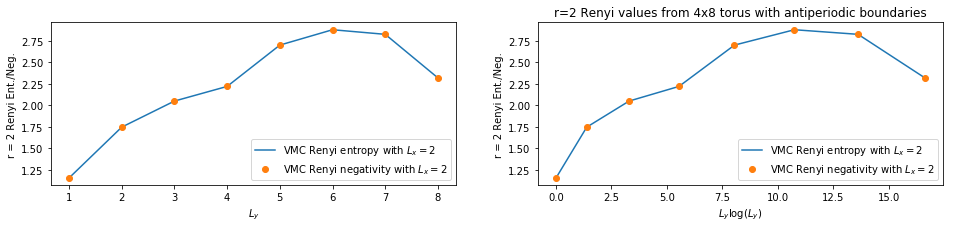

In [16]:
Nr_vmc_new2 = np.abs(Nr_vmc)
Rr_vmc_new2 = np.abs(Rr_vmc)

fig = plt.figure(figsize=(16.0, 3.0))
axes1 = fig.add_subplot(1, 2, 1)
axes1.set_ylabel("r = %d Renyi Ent./Neg." %(r))
axes1.set_xlabel('$L_y$',fontsize=10)


axes1.plot( Lx_list, Rr_vmc_new2, label = 'VMC Renyi entropy with $L_x = 2$')
axes1.plot( Lx_list, Nr_vmc_new2, 'o',label = 'VMC Renyi negativity with $L_x = 2$')
axes1.legend()

axes2 = fig.add_subplot(1, 2, 2)
axes2.set_ylabel("r = %d Renyi Ent./Neg." %(r))
axes2.set_xlabel('$L_y \log{(L_y)}$',fontsize=10)

axes2.plot( Ly_list*np.log(Ly_list), Rr_vmc_new2, label = 'VMC Renyi entropy with $L_x = 2$')
axes2.plot( Ly_list*np.log(Ly_list), Nr_vmc_new2, 'o',label = 'VMC Renyi negativity with $L_x = 2$')
axes2.legend()

plt.title('r=%d Renyi values from 4x8 torus with antiperiodic boundaries' % (r) )


plt.show()